# 🛰️ EuroSAT: Uydu Görüntüleri ile Arazi Sınıflandırma

Bu notebook, Sentinel-2 uydu görüntülerini kullanarak arazi sınıflandırması yapmak için hazırlanmıştır.

**İçerik:**
1. Kütüphanelerin Yüklenmesi
2. Veri Setinin Hazırlanması
3. Model A: Simple CNN (Baseline)
4. Model B: ResNet-18 (Feature Extraction)
5. Model C: ResNet-18 (Fine-Tuning)
6. Model Karşılaştırması ve Sonuçlar

## 1. Kütüphanelerin Yüklenmesi

In [1]:
import sys
import os

# Proje kök dizinini ayarla (sabit yol)
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PROJECT_ROOT)
sys.path.insert(0, os.path.join(PROJECT_ROOT, 'src'))

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Proje modülleri
from data_loader import download_eurosat, create_dataloaders, CLASS_NAMES, NUM_CLASSES, denormalize
from model import create_model
from train_utils import (train_model, evaluate_model, plot_training_history, 
                         plot_confusion_matrix, plot_class_performance, compare_models, load_checkpoint)

# Klasörleri oluştur
os.makedirs(os.path.join(PROJECT_ROOT, 'data'), exist_ok=True)
os.makedirs(os.path.join(PROJECT_ROOT, 'models'), exist_ok=True)
os.makedirs(os.path.join(PROJECT_ROOT, 'reports', 'figures'), exist_ok=True)

print(f"Proje Dizini: {PROJECT_ROOT}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Proje Dizini: C:\Users\ishak\PycharmProjects\Eurosat
PyTorch Version: 2.9.1+cpu
CUDA Available: False


In [2]:
# Cihaz ayarı
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Kullanılan cihaz: {device}")

# Tekrarlanabilirlik için seed
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

Kullanılan cihaz: cpu


## 2. Veri Setinin Hazırlanması

In [3]:
# Veri setini indir
DATA_DIR = os.path.join(PROJECT_ROOT, 'data')
data_path = download_eurosat(data_dir=DATA_DIR, extract_dir=DATA_DIR)

✓ Veri seti zaten mevcut: C:\Users\ishak\PycharmProjects\Eurosat\data\2750


In [4]:
# Hiperparametreler
BATCH_SIZE = 64
IMG_SIZE = 224
NUM_WORKERS = 2 # Windows için 0

# DataLoader'ları oluştur
train_loader, val_loader, test_loader, dataset_info = create_dataloaders(
    data_path=data_path,
    batch_size=BATCH_SIZE,
    train_ratio=0.8,
    val_ratio=0.1,
    num_workers=NUM_WORKERS,
    img_size=IMG_SIZE,
    seed=SEED
)


📊 VERİ SETİ BİLGİLERİ
Toplam görüntü sayısı: 27,000
Eğitim seti: 21,600 (80%)
Doğrulama seti: 2,700 (10%)
Test seti: 2,700 (10%)
Sınıf sayısı: 10
Görüntü boyutu: 224x224



C:\Users\ishak\PycharmProjects\Eurosat\.venv\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


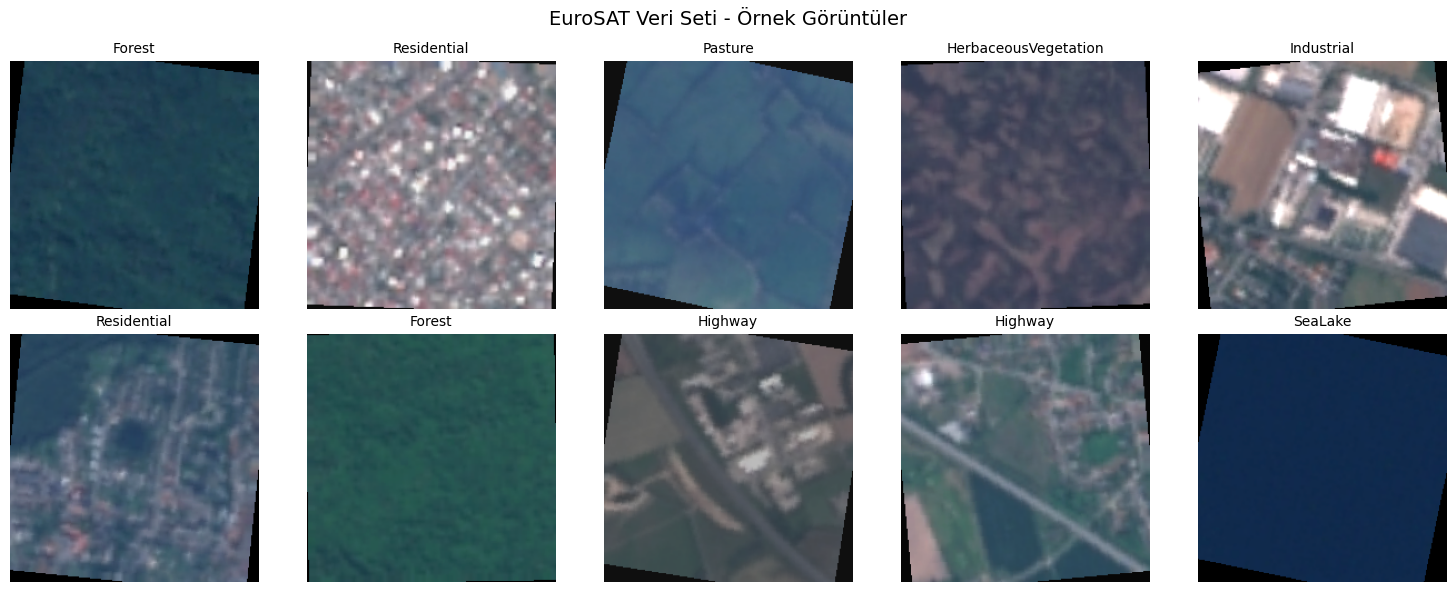

In [5]:
# Örnek görüntüleri görselleştir
images, labels = next(iter(train_loader))
images_denorm = denormalize(images)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i in range(10):
    img = images_denorm[i].permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    axes[i].set_title(CLASS_NAMES[labels[i]], fontsize=10)
    axes[i].axis('off')

plt.suptitle('EuroSAT Veri Seti - Örnek Görüntüler', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'reports', 'figures', 'sample_images.png'), dpi=300)
plt.show()

## 3. Model A: Simple CNN (Baseline)

Sıfırdan tasarlanan 4 katmanlı CNN modeli.

In [6]:
# Model A: Simple CNN
model_a = create_model('simple_cnn', num_classes=NUM_CLASSES)
model_a = model_a.to(device)

# Loss ve Optimizer
criterion = nn.CrossEntropyLoss()
optimizer_a = optim.Adam(model_a.parameters(), lr=0.001)
scheduler_a = optim.lr_scheduler.ReduceLROnPlateau(optimizer_a, mode='min', patience=2, factor=0.5)


🔧 MODEL: Simple CNN (Baseline)
Toplam parametre: 526,090
Eğitilebilir parametre: 526,090
Dondurulmuş parametre: 0



In [7]:
# Model A Eğitimi
history_a = train_model(
    model=model_a,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_a,
    scheduler=scheduler_a,
    num_epochs=15,
    device=device,
    save_path=os.path.join(PROJECT_ROOT, 'models', 'simple_cnn_best.pth'),
    early_stopping_patience=5
)


🚀 EĞİTİM BAŞLIYOR
Cihaz: cpu
Epoch sayısı: 15
Early stopping patience: 5



KeyboardInterrupt: 

In [ ]:
# Model A Eğitim Grafikleri
plot_training_history(history_a, save_path=os.path.join(PROJECT_ROOT, 'reports', 'figures', 'simple_cnn_training.png'))

In [ ]:
# Model A Değerlendirme
checkpoint_a = load_checkpoint(model_a, os.path.join(PROJECT_ROOT, 'models', 'simple_cnn_best.pth'))
metrics_a = evaluate_model(model_a, test_loader, device, CLASS_NAMES)

In [ ]:
# Model A Confusion Matrix
plot_confusion_matrix(
    metrics_a['true_labels'], 
    metrics_a['predictions'], 
    CLASS_NAMES,
    save_path=os.path.join(PROJECT_ROOT, 'reports', 'figures', 'simple_cnn_confusion_matrix.png')
)

## 4. Model B: ResNet-18 (Feature Extraction)

ImageNet üzerinde önceden eğitilmiş ResNet-18. Backbone dondurulmuş, sadece classifier eğitilir.

In [ ]:
# Model B: ResNet-18 (Frozen)
model_b = create_model('resnet18_frozen', num_classes=NUM_CLASSES, pretrained=True)
model_b = model_b.to(device)

optimizer_b = optim.Adam(filter(lambda p: p.requires_grad, model_b.parameters()), lr=0.001)
scheduler_b = optim.lr_scheduler.ReduceLROnPlateau(optimizer_b, mode='min', patience=2, factor=0.5)

In [ ]:
# Model B Eğitimi
history_b = train_model(
    model=model_b,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_b,
    scheduler=scheduler_b,
    num_epochs=10,
    device=device,
    save_path=os.path.join(PROJECT_ROOT, 'models', 'resnet18_frozen_best.pth'),
    early_stopping_patience=5
)

In [ ]:
# Model B Eğitim Grafikleri
plot_training_history(history_b, save_path=os.path.join(PROJECT_ROOT, 'reports', 'figures', 'resnet18_frozen_training.png'))

In [ ]:
# Model B Değerlendirme
checkpoint_b = load_checkpoint(model_b, os.path.join(PROJECT_ROOT, 'models', 'resnet18_frozen_best.pth'))
metrics_b = evaluate_model(model_b, test_loader, device, CLASS_NAMES)

In [ ]:
# Model B Confusion Matrix
plot_confusion_matrix(
    metrics_b['true_labels'], 
    metrics_b['predictions'], 
    CLASS_NAMES,
    save_path=os.path.join(PROJECT_ROOT, 'reports', 'figures', 'resnet18_frozen_confusion_matrix.png')
)

## 5. Model C: ResNet-18 (Fine-Tuning)

Tüm katmanlar açılarak fine-tuning yapılır. En yüksek performans beklenir.

In [ ]:
# Model C: ResNet-18 (Fine-Tuning)
model_c = create_model('resnet18_finetune', num_classes=NUM_CLASSES, pretrained=True)
model_c = model_c.to(device)

optimizer_c = optim.Adam(model_c.parameters(), lr=0.0001)
scheduler_c = optim.lr_scheduler.ReduceLROnPlateau(optimizer_c, mode='min', patience=2, factor=0.5)

In [ ]:
# Model C Eğitimi
history_c = train_model(
    model=model_c,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer_c,
    scheduler=scheduler_c,
    num_epochs=15,
    device=device,
    save_path=os.path.join(PROJECT_ROOT, 'models', 'resnet18_finetune_best.pth'),
    early_stopping_patience=5
)

In [ ]:
# Model C Eğitim Grafikleri
plot_training_history(history_c, save_path=os.path.join(PROJECT_ROOT, 'reports', 'figures', 'resnet18_finetune_training.png'))

In [ ]:
# Model C Değerlendirme
checkpoint_c = load_checkpoint(model_c, os.path.join(PROJECT_ROOT, 'models', 'resnet18_finetune_best.pth'))
metrics_c = evaluate_model(model_c, test_loader, device, CLASS_NAMES)

In [ ]:
# Model C Confusion Matrix
plot_confusion_matrix(
    metrics_c['true_labels'], 
    metrics_c['predictions'], 
    CLASS_NAMES,
    save_path=os.path.join(PROJECT_ROOT, 'reports', 'figures', 'resnet18_finetune_confusion_matrix.png')
)

In [ ]:
# Model C Sınıf Bazlı Performans
plot_class_performance(
    metrics_c, 
    CLASS_NAMES,
    save_path=os.path.join(PROJECT_ROOT, 'reports', 'figures', 'resnet18_finetune_class_performance.png')
)

## 6. Model Karşılaştırması ve Sonuçlar

In [ ]:
# Tüm modelleri karşılaştır
all_results = {
    'Simple CNN': metrics_a,
    'ResNet-18 (Frozen)': metrics_b,
    'ResNet-18 (Fine-tuned)': metrics_c
}

compare_models(all_results, save_path=os.path.join(PROJECT_ROOT, 'reports', 'figures', 'model_comparison.png'))

In [ ]:
# Detaylı karşılaştırma tablosu
print("\n" + "="*100)
print("📊 DETAYLI MODEL KARŞILAŞTIRMA TABLOSU")
print("="*100)
print(f"{'Model':<25} {'Test Acc':<12} {'F1 (Macro)':<12} {'F1 (Weighted)':<14} {'Precision':<12} {'Recall':<12}")
print("-"*100)

for name, metrics in all_results.items():
    print(f"{name:<25} "
          f"{metrics['test_accuracy']*100:>10.2f}% "
          f"{metrics['f1_macro']:>11.4f} "
          f"{metrics['f1_weighted']:>13.4f} "
          f"{metrics['precision_macro']:>11.4f} "
          f"{metrics['recall_macro']:>11.4f}")

print("="*100)

In [ ]:
# Eğitim süreçlerini karşılaştır
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss karşılaştırması
axes[0].plot(history_a['val_loss'], label='Simple CNN', linewidth=2)
axes[0].plot(history_b['val_loss'], label='ResNet-18 (Frozen)', linewidth=2)
axes[0].plot(history_c['val_loss'], label='ResNet-18 (Fine-tuned)', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Validation Loss')
axes[0].set_title('Validation Loss Karşılaştırması')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy karşılaştırması
axes[1].plot([a*100 for a in history_a['val_acc']], label='Simple CNN', linewidth=2)
axes[1].plot([a*100 for a in history_b['val_acc']], label='ResNet-18 (Frozen)', linewidth=2)
axes[1].plot([a*100 for a in history_c['val_acc']], label='ResNet-18 (Fine-tuned)', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Validation Accuracy (%)')
axes[1].set_title('Validation Accuracy Karşılaştırması')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PROJECT_ROOT, 'reports', 'figures', 'training_comparison.png'), dpi=300)
plt.show()

## 7. Sonuç

In [ ]:
# Final özet
print("\n" + "="*60)
print("🎯 PROJE SONUÇ ÖZETİ")
print("="*60)
print(f"\n✅ En İyi Model: ResNet-18 (Fine-Tuned)")
print(f"   - Test Accuracy: {metrics_c['test_accuracy']*100:.2f}%")
print(f"   - F1-Score (Macro): {metrics_c['f1_macro']:.4f}")
print(f"   - F1-Score (Weighted): {metrics_c['f1_weighted']:.4f}")
print(f"\n📁 Kaydedilen Dosyalar:")
print(f"   - {os.path.join(PROJECT_ROOT, 'models')}")
print(f"   - {os.path.join(PROJECT_ROOT, 'reports', 'figures')}")
print("="*60)

